# ROC AUC 

In [29]:
from classification import dao
from data import dao as data

In [30]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

In [31]:
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300

In [32]:
import seaborn as sns

In [33]:
from __private import fs

In [34]:
sns.set_style("darkgrid")

In [35]:
%%time
alcohol_classifier = dao.ClassifierAccess.get_byfile(
    "alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC"
)

firstperson_classifier = dao.ClassifierAccess.get_byfile(
    "first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC"
)

firstpersonlevel_classifier = dao.ClassifierAccess.get_byfile(
    "first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression"
)

CPU times: user 705 ms, sys: 441 ms, total: 1.15 s
Wall time: 22.3 s


In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


def roc(clf, X_train, y_train, X_test, y_test):

    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    y_test = label_binarize(np.array(y_test), [0,1,2])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = 3

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('First Person Label ROC')
    plt.legend(loc="lower right")
    plt.show()

In [37]:
def roc_single(clf, X_train, y_train, X_test, y_test, title):

    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    y_test = np.array(y_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [38]:
X = data.DataAccess.get_as_dataframe()
L = data.LabelGetter(X)

In [39]:
len(X)

10651

# Producing Plots

In [40]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import (
    recall_score, precision_score, 
    accuracy_score, confusion_matrix,
    classification_report)

#### First Person Levels

In [41]:
XX, y = L.get_first_person_label()

X_train, X_test, y_train, y_test = train_test_split(
    XX, y, test_size=0.33, random_state=9
)

In [42]:
clf = firstpersonlevel_classifier

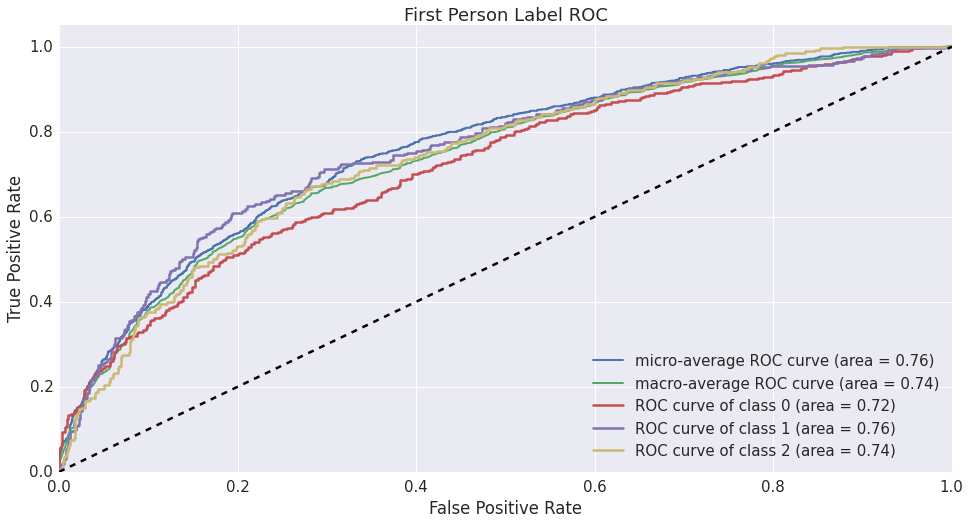

In [43]:
roc(clf, X_train, y_train, X_test, y_test)

In [44]:
# causal, looking, reflecting
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.63      0.68      0.66       528
          1       0.55      0.57      0.56       333
          2       0.51      0.40      0.45       266

avg / total       0.58      0.58      0.58      1127



#### First Person

What is good is that recall is 89 so we only lose 10% of the first person tweets when we go to first person

In [45]:
XX, y = L.get_first_person()

X_train, X_test, y_train, y_test = train_test_split(
    XX, y, test_size=0.33, random_state=42
)

In [46]:
clf = firstperson_classifier

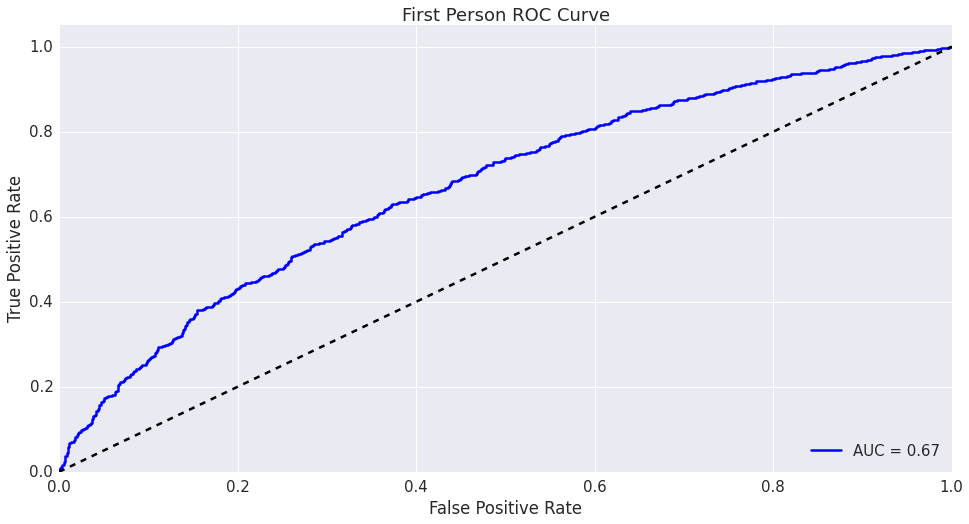

In [47]:
roc_single(clf, X_train, y_train, X_test, y_test, title="First Person ROC Curve")

In [48]:
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.58      0.49      0.53       836
          1       0.67      0.74      0.70      1149

avg / total       0.63      0.64      0.63      1985



#### Alcohol 

In [49]:
XX, y = L.get_alcohol()

X_train, X_test, y_train, y_test = train_test_split(
    XX, y, test_size=0.33, random_state=42
)

clf = alcohol_classifier

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


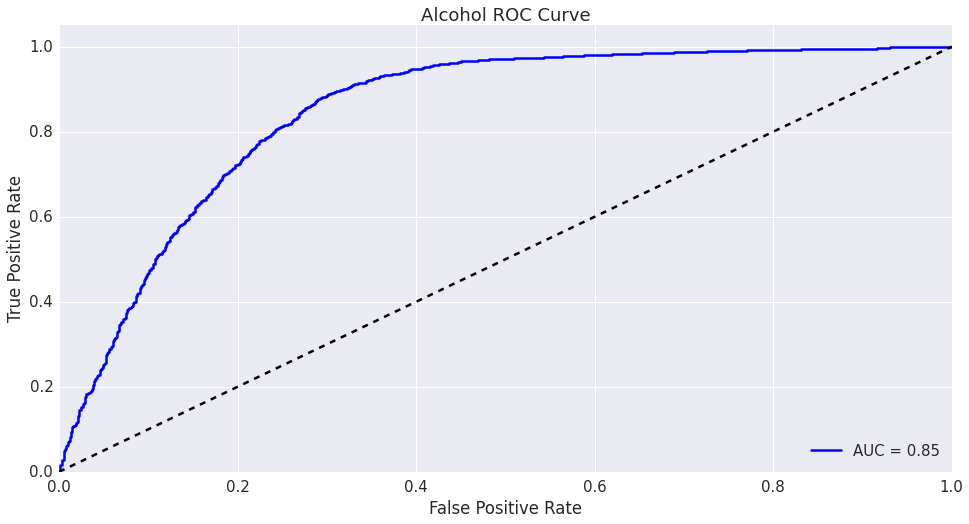

In [50]:
roc_single(clf, X_train, y_train, X_test, y_test, title="Alcohol ROC Curve")

In [51]:
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.80      0.69      0.74      1363
          1       0.82      0.89      0.85      2152

avg / total       0.81      0.81      0.81      3515

